<a href="https://colab.research.google.com/github/dzulfqr/testing/blob/master/PYIM_Assgn_2_8_Dzulfiqar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Gambar Anjing dan Kucing

#### Di dalam notebook ini, dilakukan proses end to end dalam melakukan training model yang dapat melakukan klasifikasi gambar anjing dan kucing. Data yang digunakan untuk training diperoleh dari Kaggle, berisi folder yang sudah memisahkan mana saja gambar yang merupakan 'Anjing' dan 'Kucing'.

## Persiapan

**Memperoleh Data**

In [1]:
!wget https://arjunaskykok.s3.ap-southeast-1.amazonaws.com/support/kagglecatsanddogs_3367a.zip

--2021-06-20 13:13:03--  https://arjunaskykok.s3.ap-southeast-1.amazonaws.com/support/kagglecatsanddogs_3367a.zip
Resolving arjunaskykok.s3.ap-southeast-1.amazonaws.com (arjunaskykok.s3.ap-southeast-1.amazonaws.com)... 52.219.124.27
Connecting to arjunaskykok.s3.ap-southeast-1.amazonaws.com (arjunaskykok.s3.ap-southeast-1.amazonaws.com)|52.219.124.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  17.5MB/s    in 48s     

2021-06-20 13:13:52 (16.4 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



**Unzip Data yang Sudah Diunduh**

Pastikan data masuk ke dalam Google Colab. Pastikan folder utama bernama PetImages yang mana di dalamnya terdapat folder 'Dog' dan 'Cat'

In [2]:
!unzip kagglecatsanddogs_3367a.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [3]:
!ls PetImages

Cat  Dog


**Impor Modules yang Dibutuhkan**

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

Define parameter batch size yang berperan penting dalam parallel processing, kemudian ukuran images-nya (lebar dan tinggi)

In [5]:
batch_size = 32
img_height = 256
img_width = 256

Jika dalam analisis data biasanya masih diperlukan proses Data Engineering untuk memanipulasi data yang tidak lengkap, dalam pembuatan model klasifikasi images ini ternyata perlu dilakukan proses eliminasi images yang corrupted, sebagai berikut

In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Berhasil menghapus %d images" % num_skipped)

Berhasil menghapus 1590 images


Kemudian, kita pisahkan data validasi dan training dengan memanfaatkan salah satu fungsi dalam Keras yang langsung dapat membuat Dataset Tensorflow dari directory.

In [7]:
data_dir = 'PetImages'

In [8]:
PetImages_val = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size, smart_resize=True)

Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [9]:
PetImages_train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size, smart_resize=True)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.


Memastikan bahwa hanya ada dua class yaitu ['Cat', 'Dog']

In [10]:
class_names = PetImages_train.class_names
print(class_names)

['Cat', 'Dog']


## Visualisasi Data

Kode berikut digunakan untuk memvisualisasi beberapa data yang masuk ke dalam training data, dengan labelnya (X train dan y train).

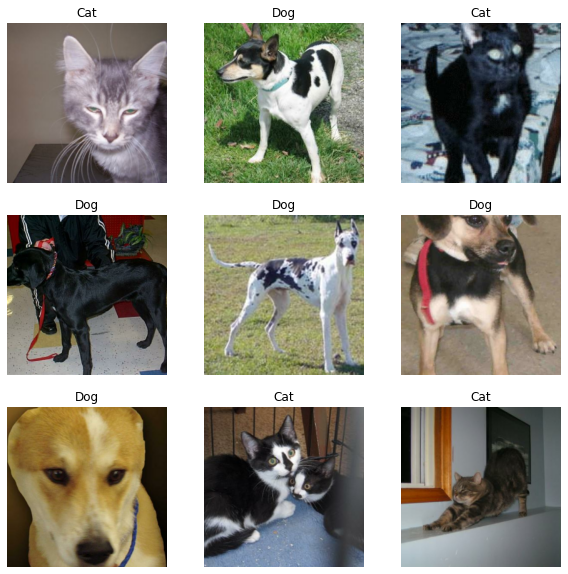

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in PetImages_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation
Proses ini akan sangat membantu kita dalam mengoptimalkan model karena kita menambahkan training dataset yang berupa foto anjing atau kucing dari sisi lainnya melalui proses flipping dan rotating. Hal ini bisa dengan mudah kita lakukan dengan module preprocessing juga dari Keras.

In [14]:
from tensorflow.keras import layers
image_size = (img_height, img_width)
image_size

(256, 256)

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"), # melakukan proses flipping
        layers.experimental.preprocessing.RandomRotation(0.2), # melakukan proses rotasi
    ]
)

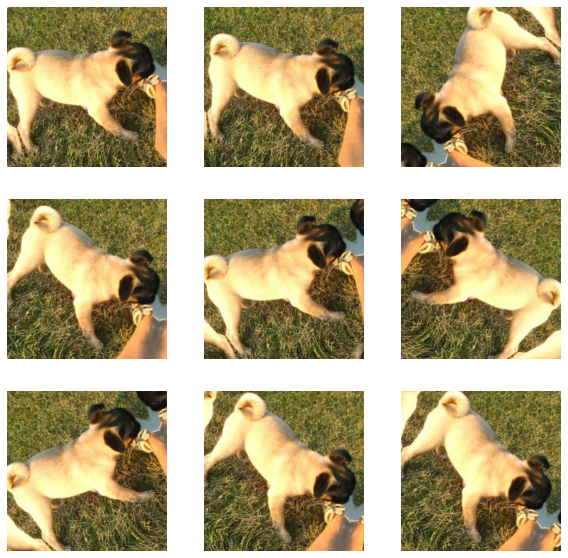

In [16]:
# Visualisasi data jika dilakukan augmentation
plt.figure(figsize=(10, 10))
for images, _ in PetImages_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Normalisasi Data
Ini merupakan tahap yang penting agar proses training bisa menjadi lebih stabil.

In [17]:
# input_shape=image_size + (3,)
# inputs = tf.keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.experimental.preprocessing.Rescaling(1./255)(x)

Bagian normalisasi data bisa kita masukan saja ke dalam function yang akan melakukan data training.

## Konfigurasi Dataset

Prefetch terhadap dataset dilakukan untuk transfer (data) dari memori utama ke penyimpanan sementara untuk digunakan nantinya.

In [22]:
train_ds = PetImages_train.prefetch(buffer_size=16)
val_ds = PetImages_val.prefetch(buffer_size=16)

## Function untuk Data Training

Pada kode di bawah, ditambahkan pula bagian yang akan improve model yang dibuat yaitu dengan memberlakukan project residual. Hal ini akan mencegah degradasi model, kasus di mana ketika menambahkan layer atau meningkatkan kompleksitas network justru akan memperbesar error.

In [23]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Blok untuk augmentation (yang didefinisikan di atas)
    x = data_augmentation(inputs)

    # Blok awal
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Menambahkan residual
        previous_block_activation = x  # Set residual berikutnya

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    activation = "sigmoid" # dikarenakan ada 2 jumlah class-nya
    units = 1
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs) # return Model

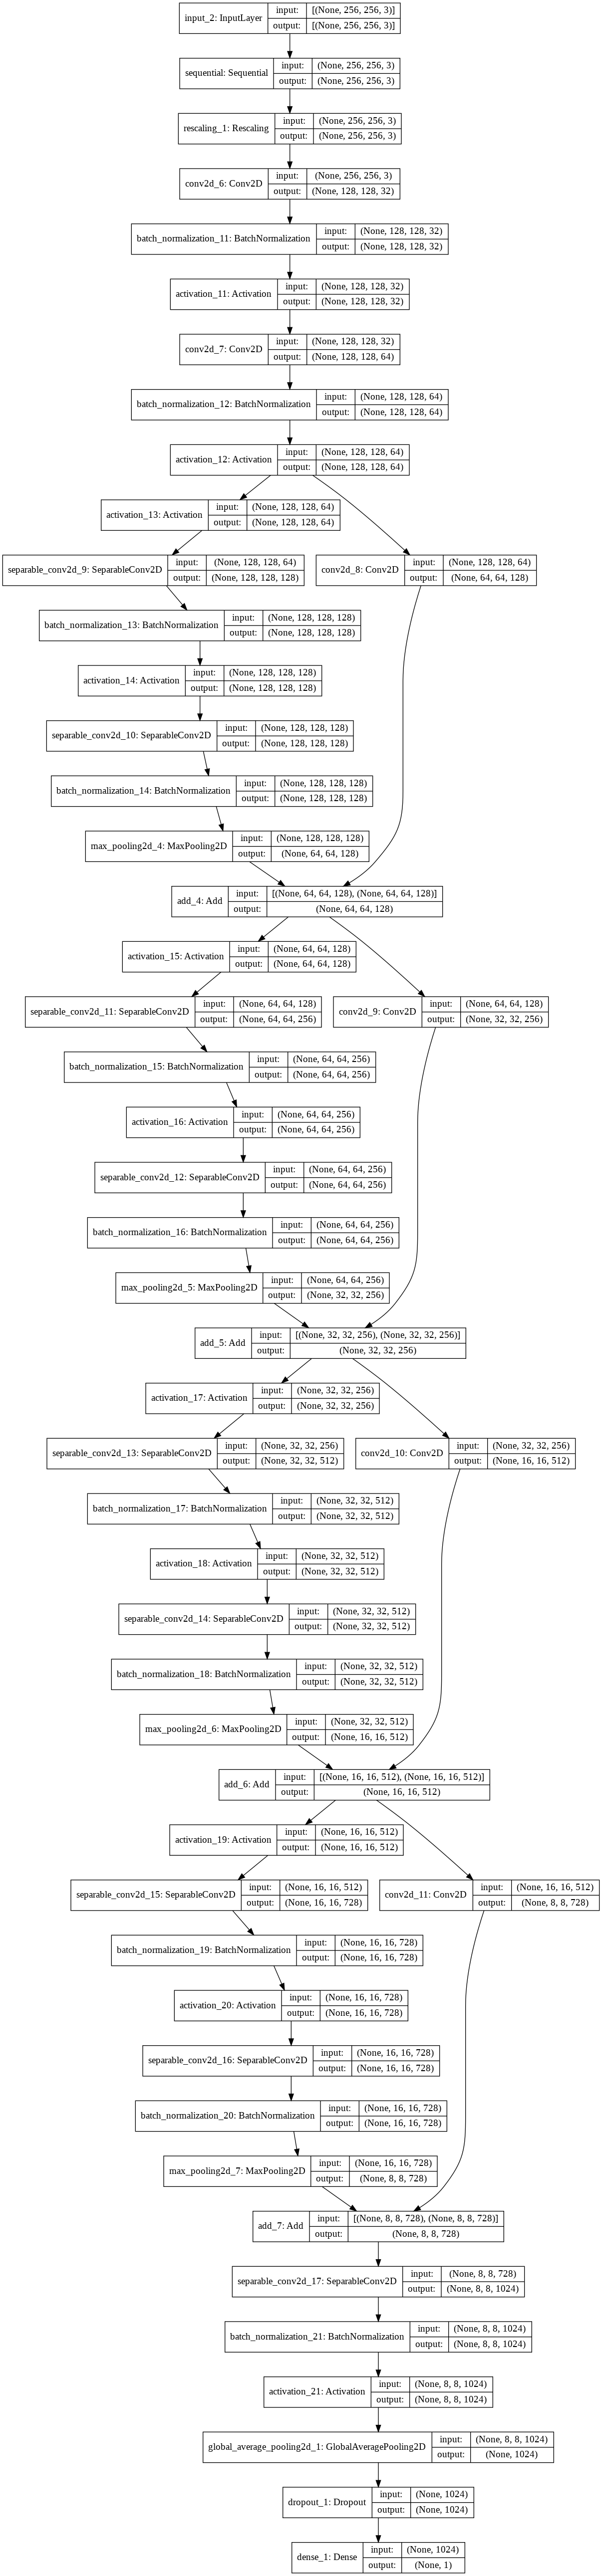

In [24]:
# Visualisasi diagram model yang telah dibuat
model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
# Menentukan jumlah epoch atau iterasi yang akan dilakukan dalam model fitting
epochs = 25

# Melakukan checkpoint di mana model yang dibuat setiap iterasinya akan tersimpan
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
# Compile model, optimizer yang digunakan Adam, loss binary crossentropy karena class nya hanya 2 (bukan multiclass)
# Metrics yang digunakan untuk evaluasi model: Accuracy.
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)
# Fitting model berdasar parameter parameter tersebut.
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 287s 485ms/step - loss: 0.6539 - accuracy: 0.6376 - val_loss: 0.6962 - val_accuracy: 0.6510


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
586/586 [==============================] - 284s 483ms/step - loss: 0.5491 - accuracy: 0.7310 - val_loss: 0.7818 - val_accuracy: 0.6476
Epoch 3/25
586/586 [==============================] - 283s 482ms/step - loss: 0.4644 - accuracy: 0.7896 - val_loss: 0.4539 - val_accuracy: 0.7956
Epoch 4/25
586/586 [==============================] - 283s 482ms/step - loss: 0.4023 - accuracy: 0.8215 - val_loss: 0.3778 - val_accuracy: 0.8334
Epoch 5/25
586/586 [==============================] - 284s 483ms/step - loss: 0.3498 - accuracy: 0.8494 - val_loss: 0.3247 - val_accuracy: 0.8618
Epoch 6/25
586/586 [==============================] - 283s 483ms/step - loss: 0.3115 - accuracy: 0.8707 - val_loss: 0.2941 - val_accuracy: 0.8716
Epoch 7/25
586/586 [==============================] - 283s 483ms/step - loss: 0.2772 - accuracy: 0.8878 - val_loss: 0.3204 - val_accuracy: 0.8616
Epoch 8/25
586/586 [==============================] - 283s 482ms/step - loss: 0.2403 - accuracy: 0.9018 - val_loss: 0.4203 -

# Akurasi model final adalah sekitar 95.45%

In [26]:
# Visualisasi dan implementasi model pada salah satu image
img = tf.keras.preprocessing.image.load_img(
    "PetImages/Cat/6000.jpg", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "Gambar ini merupakan %.2f persen kucing dan %.2f persen anjing."
    % (100 * (1 - score), 100 * score)
)

Gambar ini merupakan 100.00 persen kucing dan 0.00 persen anjing.


In [27]:
# Visualisasi dan implementasi model pada salah satu image
img = tf.keras.preprocessing.image.load_img(
    "PetImages/Dog/6000.jpg", target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "Gambar ini merupakan %.2f persen kucing dan %.2f persen anjing."
    % (100 * (1 - score), 100 * score)
)

Gambar ini merupakan 0.19 persen kucing dan 99.81 persen anjing.
